# Plotting

```{versionadded} 0.5.2
`%sqlplot` was introduced in 0.5.2; however, the underlying
[Python API](api/python) was introduced in 0.4.4
```


The most common way for plotting datasets in Python is to load them using pandas and then use matplotlib or seaborn for plotting. This approach requires loading all your data into memory which is highly inefficient, since you can easily run out of memory as you perform data transformations.

The plotting module in JupySQL runs computations in the SQL engine (database, warehouse, or embedded engine). This delegates memory management to the engine and ensures that intermediate computations do not keep eating up memory, allowing you to efficiently plot massive datasets. There are two primary use cases:

**1. Plotting large remote tables**

If your data is stored in a data warehouse such as Snowflake, Redshift, or BigQuery, downloading entire tables locally is extremely inefficient, and you might not even have enough memory in your laptop to load the entire dataset. With JupySQL, the data is aggregated and summarized in the warehouse, and only the summary statistics are fetched over the network. Keeping memory usage at minimum and allowing you to quickly plot entire warehouse tables efficiently.

**2. Plotting large local files**

If you have large `.csv` or `.parquet` files, plotting them locally is challenging. You might not have enough memory in your laptop. Furthermore, as you transform your data, those transformed datasets will consume memory, making it even more challenging. With JupySQL, loading, aggregating, and summarizing is performed in DuckDB, an embedded SQL engine; allowing you to plot larger-than-memory datasets from your laptop.

## Download data

In this example, we'll demonstrate this second use case and query a `.parquet` file using DuckDB. However, the same code applies for plotting data stored in a database or data warehoouse such as Snowflake, Redshift, BigQuery, PostgreSQL, etc.

In [1]:
from pathlib import Path
from urllib.request import urlretrieve

url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet"

if not Path("yellow_tripdata_2021-01.parquet").is_file():
    urlretrieve(url, "yellow_tripdata_2021-01.parquet")

## Setup

```{note}
`%sqlplot` requires `matplotlib`: `pip install matplotlib` and this example requires
duckdb-engine: `pip install duckdb-engine`
```

Load the extension and connect to an in-memory DuckDB database:

In [2]:
%load_ext sql

In [3]:
%sql duckdb://

We'll be using a sample dataset that contains historical taxi data from NYC:

## Data preview

In [4]:
%%sql
SELECT * FROM "yellow_tripdata_2021-01.parquet" LIMIT 3

*  duckdb://
Done.


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.1,1.0,N,142,43,2,8.0,3.0,0.5,0.0,0.0,0.3,11.8,2.5,None
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.2,1.0,N,238,151,2,3.0,0.5,0.5,0.0,0.0,0.3,4.3,0.0,None
1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.7,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,None


In [5]:
%%sql
SELECT COUNT(*) FROM "yellow_tripdata_2021-01.parquet"

*  duckdb://
Done.


count_star()
1369769


## Boxplot

```{note}
To use `%sqlplot boxplot`, your SQL engine must support:

`percentile_disc(...) WITHIN GROUP (ORDER BY ...)`

[Snowflake](https://docs.snowflake.com/en/sql-reference/functions/percentile_disc.html),
[Postgres](https://www.postgresql.org/docs/9.4/functions-aggregate.html),
[DuckDB](https://duckdb.org/docs/sql/aggregates), and others support this.
```

To create a boxplot, call `%sqlplot boxplot`, and pass the name of the table, and the column you want to plot. Since we're using DuckDB for this example, the table is the path to the parquet file.

<Axes: title={'center': "'trip_distance' from 'yellow_tripdata_2021-01.parquet'"}, ylabel='trip_distance'>

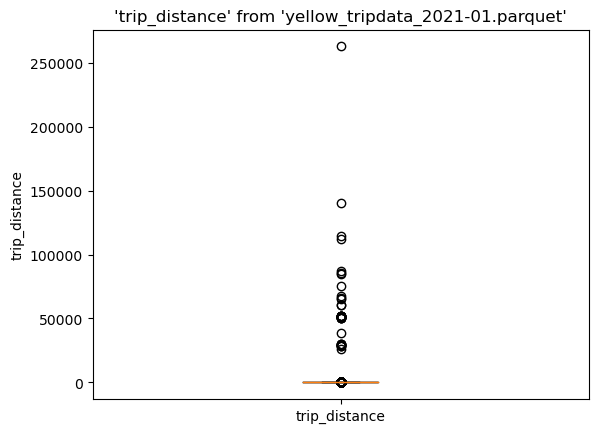

In [6]:
%sqlplot boxplot --table yellow_tripdata_2021-01.parquet --column trip_distance

There are many outliers in the data, let's find the 90th percentile to use it as cutoff value, this will allow us to create a cleaner visulization:

In [7]:
%%sql
SELECT percentile_disc(0.90) WITHIN GROUP (ORDER BY trip_distance),
FROM 'yellow_tripdata_2021-01.parquet'

*  duckdb://
Done.


quantile_disc(0.90 ORDER BY trip_distance)
6.3


Now, let's create a query that filters by the 90th percentile. Note that we're using the `--save`, and `--no-execute` functions. This tells JupySQL to store the query, but *skips execution*. We'll reference it in our next plotting call.

In [8]:
%%sql --save short_trips --no-execute
SELECT *
FROM "yellow_tripdata_2021-01.parquet"
WHERE trip_distance < 6.3

*  duckdb://
Skipping execution...


Now, let's plot again, but this time let's pass `--table short_trips`. Note that this table *doesn't exist*; however, since we're passing the `--with` argument, JupySQL will use the query we defined above:

<Axes: title={'center': "'trip_distance' from 'short_trips'"}, ylabel='trip_distance'>

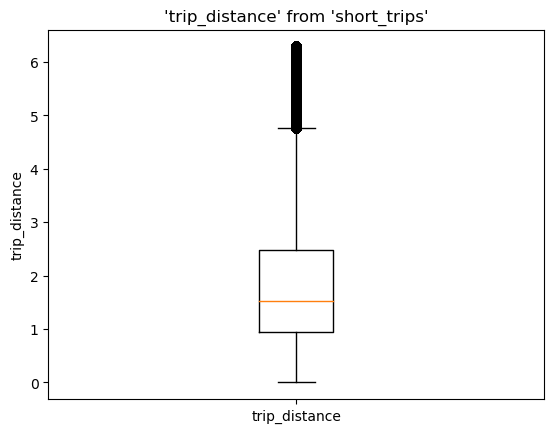

In [9]:
%sqlplot boxplot --table short_trips --column trip_distance --with short_trips

We can see the highest value is a bit over 6, that's expected since we set a 6.3 cutoff value.

## Histogram

To create a histogram, call `%sqlplot histogram`, and pass the name of the table, the column you want to plot, and the number of bins. Similarly to what we did in the [Boxplot](#boxplot) example, we're using `--with short_trips` so JupySQL uses the query we defined and only plots such data subset.

<Axes: title={'center': "'trip_distance' from 'short_trips'"}, xlabel='trip_distance', ylabel='Count'>

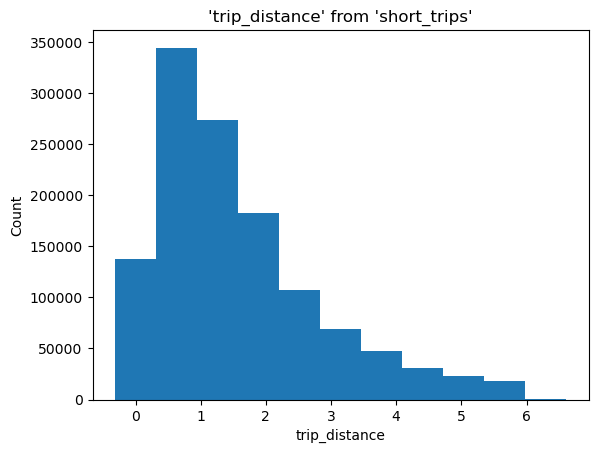

In [10]:
%sqlplot histogram --table short_trips --column trip_distance --bins 10 --with short_trips

## Customize plot

`%sqlplot` returns a `matplotlib.Axes` object that you can further customize:

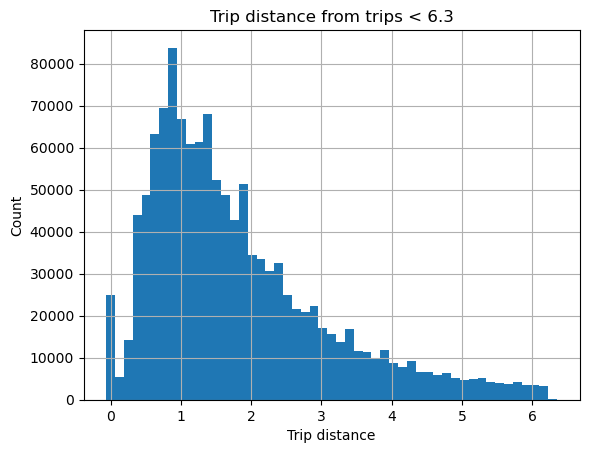

In [11]:
ax = %sqlplot histogram --table short_trips --column trip_distance --bins 50 --with short_trips
ax.grid()
ax.set_title("Trip distance from trips < 6.3")
_ = ax.set_xlabel("Trip distance")